###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018 D. Koehn, notebook style sheet by L.A. Barba, N.C. Clementi

###### Translated by Huizhe Di @ SCSIO

# 三角网格生成

在上一课中，我们学习了如何通过超限插值创建一个四边形网格来精确地近似海堤的强地形。我们可以使用这个网格进行谱元法建模。但是，如果我们需要一个三角形网格，例如在有限元建模中，我们该怎么做呢?

## Yigma Tepe - 强烈地形变化的另一个问题

你可能会认为海堤的地形已经相当复杂了. 好吧，这是我们现在工作的另一个问题:

<img src="images/yigmatepe_1.jpg" width="100%">

这是 [Yigma Tepe](https://vici.org/vici/42048/?lang=en), 一个可能是阿提拉德国王的坟墓，位于佩加蒙(土耳其). 随着地球物理勘探[geophysical prospecting](https://publications.dainst.org/journals/index.php/efb/article/view/1562/4464) 考古发掘的深入[archaeological excavations](https://www.archaeologie-online.de/nachrichten/neue-forschungen-zu-den-antiken-grabhuegeln-der-welterbestaette-pergamon-2937/) 伊格马特佩发现了小尺度近地表构造，是考古勘探领域进一步开展二维SH和三维地震全波形反演的理想目标。一个关键部分是对复杂自由表面形貌的正确离散，这对精确模拟表面波至关重要。

让我们看一个二维四分网格通过超限插值.

In [1]:
# Import Libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Here, I introduce a new library, which is useful 
# to define the fonts and size of a figure in a notebook
from pylab import rcParams

# Get rid of a Matplotlib deprecation warning
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load Yigma Tepe quad mesh created by TFI
X = np.loadtxt('data/yigma_tepe_TFI_mesh_X.dat', delimiter=' ', skiprows=0, unpack='True')
Z = np.loadtxt('data/yigma_tepe_TFI_mesh_Z.dat', delimiter=' ', skiprows=0, unpack='True')

# number of grid points in each spatial direction
NZ, NX = np.shape(X)
print("NX = ", NX)
print("NZ = ", NZ)

NX =  70
NZ =  10


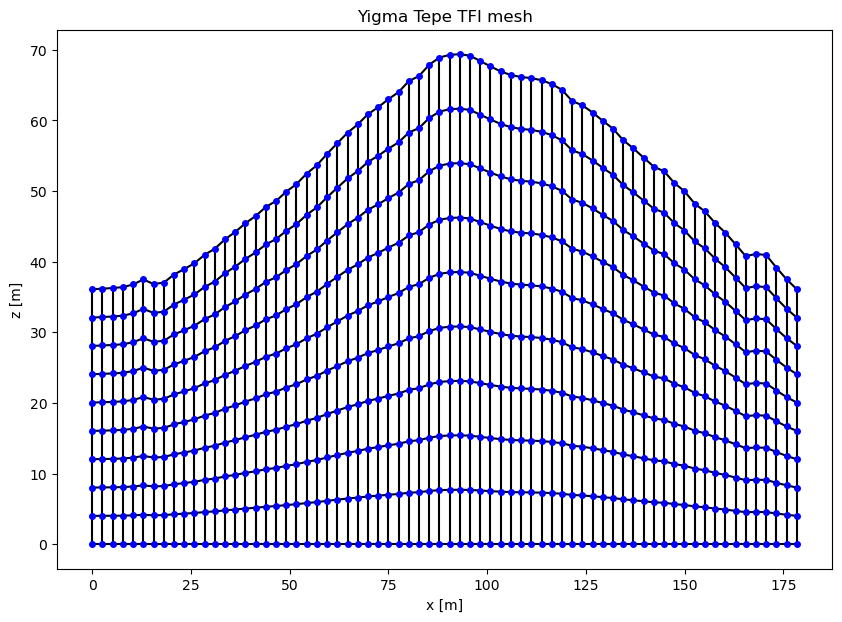

In [3]:
# Define figure size
rcParams['figure.figsize'] = 10, 7

# Plot Yigma Tepe TFI mesh
plt.plot(X, Z, 'k')
plt.plot(X.T, Z.T, 'k')
plt.plot(X, Z, 'bo', markersize=4)

plt.title("Yigma Tepe TFI mesh" )
plt.xlabel("x [m]")
plt.ylabel("z [m]")
# plt.axes().set_aspect('equal')
# plt.savefig('yigma_tepe_TFI.pdf', bbox_inches='tight', format='pdf')
plt.show()

这种四边形网格已经能够准确地描述自由表面的地形。

## 三角网格生成

如果我们需要一个三角形网格，例如有限元或有限体积建模, 我们可以使用 **Delaunay三角剖分** 可以对Yigma Tepe TFI网格的节点分布. 更多关于Delaunay三角剖分的细节 , 我参考了 [Computational Geometry in Python](http://blancosilva.github.io/post/2014/10/28/Computational-Geometry-in-Python.html) by Francisco Blanco-Silva. 

在第一步中，我们将x和z向量集合到一个 (NX*NZ x 2) 矩阵中.

In [4]:
# Reshape X and Z vector
x = X.flatten()
z = Z.flatten()

# Assemble x and z vector into NX*NZ x 2 matrix
points = np.vstack([x,z]).T

接下来，我们计算网格点的 **Voronoi图**. 这描述了将一个有n个点的平面划分为凸多边形，每个多边形只包含一个生成点，并且给定多边形中的每个点都比其他任何点更接近它的生成点。

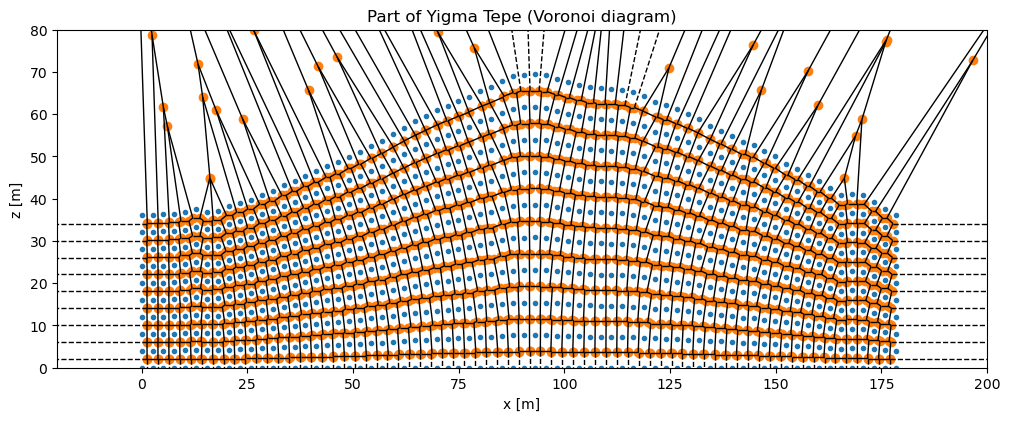

In [5]:
# calculate and plot Voronoi diagram for mesh points
from scipy.spatial import Voronoi, voronoi_plot_2d

vor = Voronoi(points)

plt.figure(figsize=(12,6))
ax = plt.subplot(111, aspect='equal')
voronoi_plot_2d(vor, ax=ax)

plt.title("Part of Yigma Tepe (Voronoi diagram)" )
plt.xlabel("x [m]")
plt.ylabel("z [m]")
plt.xlim(-20,200)
plt.ylim(0,80)
plt.show()

The **Delaunay triangulation** 通过连接相邻Voronoi细胞中的点来创建三角形.

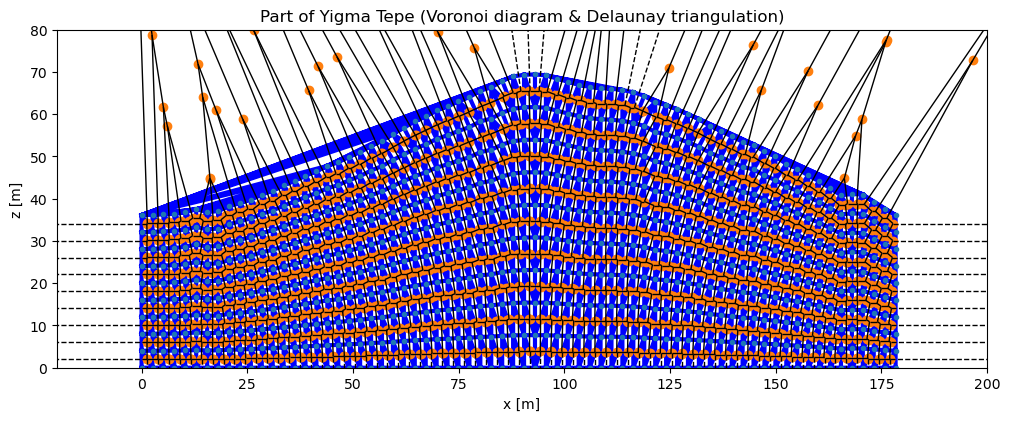

In [6]:
# Apply Delaunay triangulation to the quad mesh node points
from scipy.spatial import Delaunay

tri = Delaunay(points)

plt.figure(figsize=(12,6))
ax = plt.subplot(111, aspect='equal')
voronoi_plot_2d(vor, ax=ax)
plt.triplot(points[:,0], points[:,1], tri.simplices.copy(), linewidth=3, color='b')
plt.title("Part of Yigma Tepe (Voronoi diagram & Delaunay triangulation)" )
plt.xlabel("x [m]")
plt.ylabel("z [m]")
plt.xlim(-20,200)
plt.ylim(0,80)
plt.show()

让我们来看看Yigma Tepe模型的最终网格。

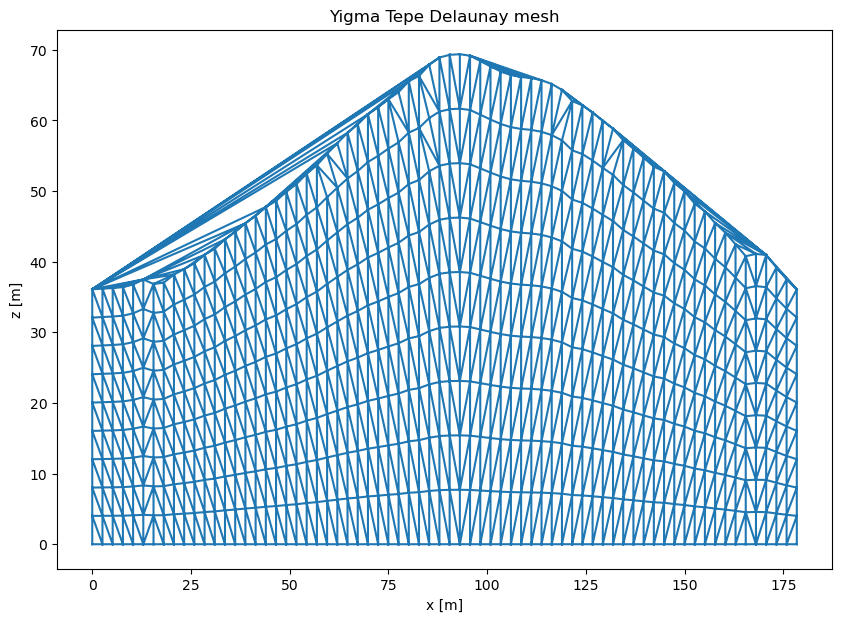

In [7]:
# Plot triangular mesh
plt.triplot(points[:,0], points[:,1], tri.simplices.copy())
plt.title("Yigma Tepe Delaunay mesh" )
plt.xlabel("x [m]")
plt.ylabel("z [m]")
# plt.axes().set_aspect('equal')
plt.show()

尽管此方法大体上很合理，然而，其也在地形上方增加了多余的三角形。为了解决这一问题，我们必须使用约束Delaunay三角剖分，以限制三角剖分到自由曲面地形下的模型。不幸的是，约束Delaunay三角测量在“SciPy”中不可用。

然而， `python` 包 [Triangle](http://www.cs.cmu.edu/~quake/triangle.html) by Richard Shewchuck. This wrapper can be installed by 

* `git clone --depth=1 https://github.com/drufat/triangle.git`
* `cd triangle`
* `python setup.py install`

A detailed documentation of the Triangle Python wrapper by [Dzhelil Rufat](http://dzhelil.info/index.html) can be found [here](http://dzhelil.info/triangle/).

In [13]:
# import triangulate library
from triangle import triangulate, show_data
import triangle.plot as tplot
import triangle

为了使用约束Delaunay三角剖分，我们显然必须定义位于模型边界上的约束顶点。在这种情况下是相当容易的，因为TFI网格是规则的。 

也许没那么简单，因为我们必须确保在最终列表中没有多余的点并且这些点是按顺时针方向顺序定义的。

In [14]:
# Estimate boundary points 

# surface topography
surf = np.vstack([X[9,:-2],Z[9,:-2]]).T

# right model boundary
right = np.vstack([X[1:,69],Z[1:,69]]).T

# bottom model boundary
bottom = np.vstack([X[0,1:],Z[0,1:]]).T

# left model boundary
left = np.vstack([X[:-2,0],Z[:-2,0]]).T

# assemble model boundary
model_stack = np.vstack([surf,np.flipud(right)])
model_stack1 = np.vstack([model_stack,np.flipud(bottom)])
model_bound = np.vstack([model_stack1,left])

上面的代码看起来有点混乱，但是您可以检查结果数组model_bound中的点是否正确排序，并且不包含冗余点。

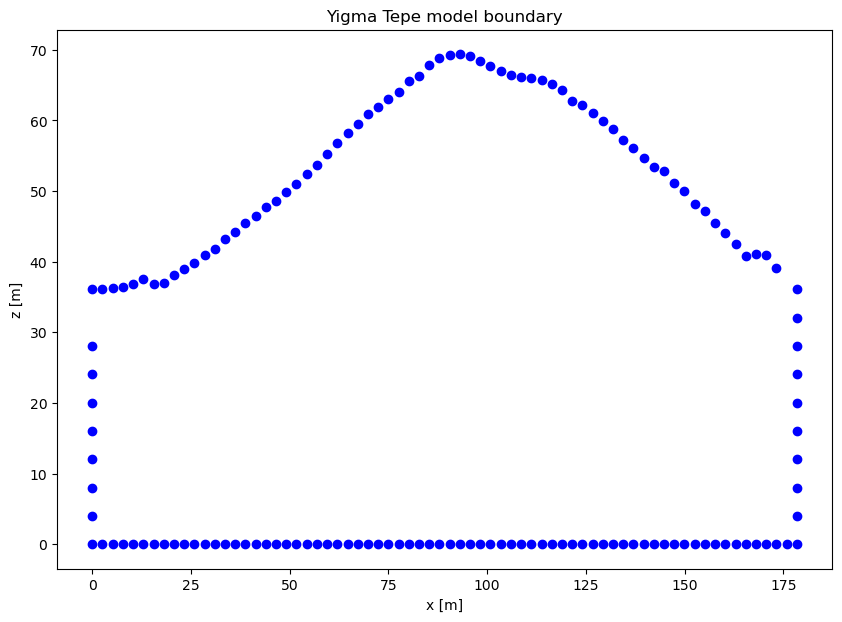

In [15]:
plt.plot(model_bound[:,0],model_bound[:,1],'bo')
plt.title("Yigma Tepe model boundary" )
plt.xlabel("x [m]")
plt.ylabel("z [m]")
# plt.axes().set_aspect('equal')
plt.show()


很好，现在我们已经定义了模型边界点。 一些时间 **限制Delaunay三角** ...

In [16]:
# define vertices (no redundant points)
vert = model_bound

# apply Delaunay triangulation to vertices
tri = triangle.delaunay(vert)

# define vertex markers
vertm = np.array(np.zeros((len(vert),1)),dtype='int32')

# define how the vertices are connected, e.g. point 0 is connected to point 1, 
# point 1 to point 2 and so on ... 
points1 = np.arange(len(vert))
points2 = np.arange(len(vert))+1

# last point is connected to the first point
points2[-1] = 0

# define connectivity of boundary polygon
seg = np.array(np.vstack([points1,points2]).T,dtype='int32')

# define marker for boundary polygon
segm = np.array(np.ones((len(seg),1)),dtype='int32')

# assemble dictionary for triangle optimisation
A = dict(vertices=vert, vertex_markers=vertm, segments=seg, segment_markers=segm,triangles=tri)

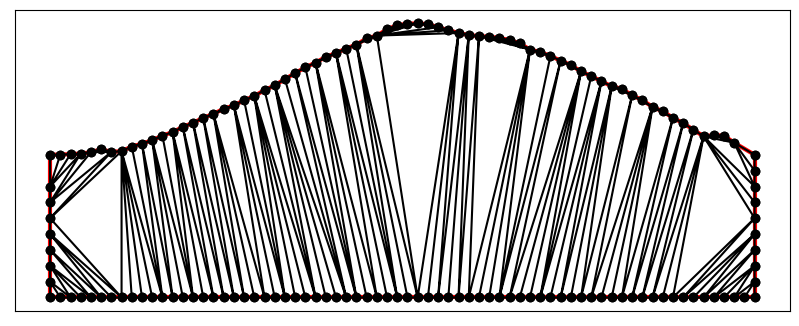

In [18]:
# Optimise initial triangulation
cndt = triangle.triangulate(A,'pD')
ax = plt.subplot(111, aspect='equal')
tplot(ax,**cndt)

Very good, compared to the `SciPy` Delaunay triangulation, no triangles are added above the topography. However, most triangles have very small minimum angles, which would lead to serious numerical issues in later finite element modelling runs. So in the next step we restrict the minimum angle to 20° using the option `q20`.

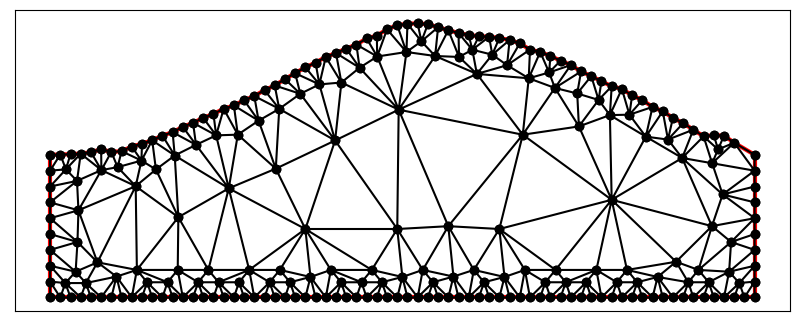

In [19]:
cncfq20dt = triangulate(A,'pq20D')
ax = plt.subplot(111, aspect='equal')
tplot(ax,**cncfq20dt)

Finally, we want a more evenly distribution of the triangle sizes. This can be achieved by imposing a maximum area to the triangles with the option `a20`.

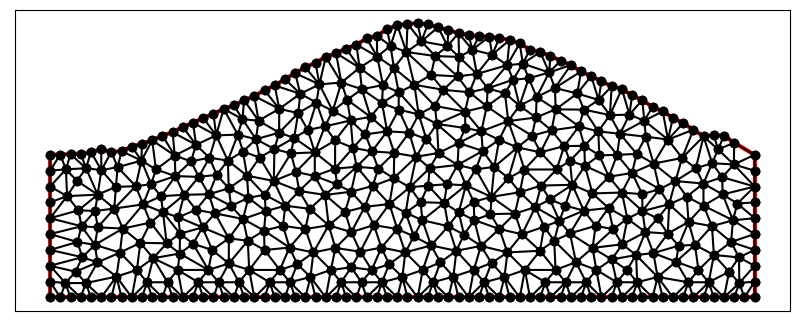

In [20]:
cncfq20adt = triangulate(A,'pq20a20D')
ax = plt.subplot(111, aspect='equal')
tplot(ax,**cncfq20adt)

Compared to the `SciPy` Delaunay triangulation, the optimized mesh created by constrained Delaunay triangulation correctly describes the free-surface topography and can be used for modelling of seismic wave propagation with finite element or finite volume methods.

## Mesh generators

We have seen, that mesh generation from scratch can be quite time-consuming, even for a simple model geometry. Therefore, it is recommended to use mesh generators. Here, I summarize a few of the most popular codes:

* [CUBIT](https://cubit.sandia.gov/) developed by Sandia national laboratories, CUBIT is the most widely used mesh generator. A disadvantage of the code is that it is only available for users employed in the US government.

* [TRELIS](https://www.csimsoft.com/trelis.jsp) This is the international version of CUBIT. However, it has an annual lease license.

As mentioned in the introduction, my philosopy is that science should rely on OpenSource codes in order to achieve reproducible research. Therefore, I prefer OpenSource meshers, e.g.:

* [Gmsh](http://gmsh.info/) developed by Christophe Geuzaine and Jean-François Remacle, Gmsh can create triangular, tetrahedral, quad and hex meshes. Gmsh also has some visualization capabilites for post-processing.

* [Tetgen](http://wias-berlin.de/software/index.jsp?id=TetGen&lang=1) developed by Hang Si, can produce tetrahedral meshes. 

* We already used [Triangle](https://www.cs.cmu.edu/~quake/triangle.html) together with a Python wrapper in this Jupyter notebook to create a 2D triangular mesh for the Yigma Tepe tumulus. More complex triangular meshes can also be created with Triangle. 

* Another nice Python interface for Triangle and Tetgen is [MeshPy](https://mathema.tician.de/software/meshpy/) by Andreas Klöckner.

## We learned:

* How to read and display an external regular TFI mesh for the Yigma Tepe tumulus
* Building a Voronoi diagram and triangular Delaunay mesh based on the regular TFI quad mesh node points
* Building a triangular mesh for the Yigma Tepe tumulus from scratch using constrained Delaunay triangulation
* Triangular mesh generation is even more time-consuming than for the quad mesh
* For complex 2D/3D model geometries it is recommend to use a mesh generator like Gmsh , Triangle or Tetgen